### LSTM per Serie univariate - previsione multistep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras import metrics

from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

agg_by_cell = data.groupby(by = ['cell_num'])
one_cell = agg_by_cell.get_group('486-1252')
series = one_cell['nr_people'].values
print(type(series))

/Users/alket/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'numpy.ndarray'>


In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
         # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
         # check if we are beyond the sequence
         if out_end_ix > len(sequence):
             break
         # gather input and output parts of the pattern
         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 8, 4

# split into samples
X, y = split_sequence(series, n_steps_in, n_steps_out)
count = 0
for i in range(len(X)):
    print(X[i], y[i])
    count +=1
    if count>5: break

[36. 36. 34. 33. 32. 33. 32. 30.] [30. 29. 29. 27.]
[36. 34. 33. 32. 33. 32. 30. 30.] [29. 29. 27. 27.]
[34. 33. 32. 33. 32. 30. 30. 29.] [29. 27. 27. 25.]
[33. 32. 33. 32. 30. 30. 29. 29.] [27. 27. 25. 24.]
[32. 33. 32. 30. 30. 29. 29. 27.] [27. 25. 24. 23.]
[33. 32. 30. 30. 29. 29. 27. 27.] [25. 24. 23. 22.]


### Normalizzazione

In [3]:
"""
# normalize    
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(X)
# apply transform
X = scaler.transform(X)

# fit scaler on data
y = y.reshape(-1, 1)
scaler.fit(y)
# apply transform
y = scaler.transform(y)
"""

'\n# normalize    \nscaler = MinMaxScaler()\n# fit scaler on data\nscaler.fit(X)\n# apply transform\nX = scaler.transform(X)\n\n# fit scaler on data\ny = y.reshape(-1, 1)\nscaler.fit(y)\n# apply transform\ny = scaler.transform(y)\n'

In [4]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

### Dividi i dati in train-validation-test

In [5]:
train_size = 8000
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]
print(len(train_X), len(train_y), len(test_X), len(test_y))

8000 8000 3797 3797


### Modello LSTM

In [6]:
# define model
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(RepeatVector(n_steps_out))
model.add(LSTM(20, activation='relu', return_sequences=True)) 
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse',metrics=[metrics.mae, 'accuracy'] )
# fit model
model.fit(train_X, train_y, epochs=8, verbose=2)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array.

### Dimostra previsione

In [37]:
# demonstrate prediction
x_input = np.array([25, 24, 23, 23, 24, 22, 21, 20])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[19.379837]
  [21.22578 ]
  [21.088663]
  [20.889215]]]


### Calcolo dell'errore

Mean Absolute Error =  1.8677117270107235


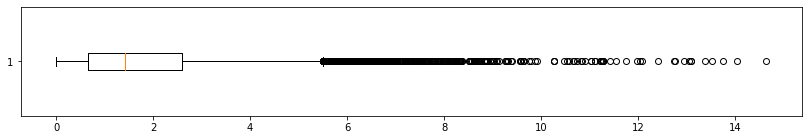

In [41]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    # x_input = X[i].reshape((1, n_steps))
    x_input = test_X[i].reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    predicted = np.append(predicted, yhat[0]) 


expected = test_y
expected = np.reshape(expected, (expected.shape[0]*expected.shape[1]))
# abs difference
difference = abs((expected - predicted))

print('Mean Absolute Error = ', np.mean(difference))
# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert= False);
plt.show()

### Trova numero di neuroni ottimo 

number of nodes=100: 2.061
number of nodes=200: 1.998
number of nodes=300: 2.054
number of nodes=400: 2.013
number of nodes=500: 2.625
number of nodes=600: 2.107


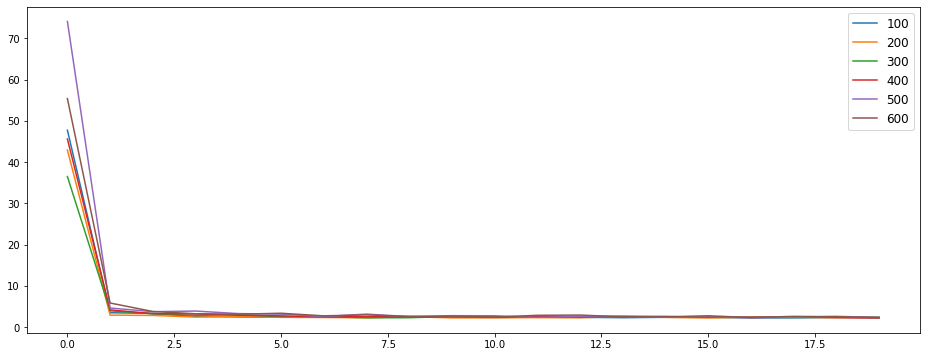

In [18]:
# fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_nodes, train_X, train_y, val_X, val_y):
    
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_steps, n_features))) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
   
    # fit model
    history = model.fit(train_X, train_y, epochs=20, verbose=0)
    
    test_acc = model.evaluate(val_X, val_y, verbose=0)
    return history, test_acc  

plt.figure(figsize = (16, 6))
num_nodes = [100, 200, 300, 400, 500, 600]

for n_nodes in num_nodes:
    # evaluate model with a given number of nodes
    history, result = evaluate_model(n_nodes, train_X, train_y, test_X, test_y)
        
    # summarize final test set accuracy
    print('number of nodes=%d: %.3f' % (n_nodes, result))
         
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_nodes))       
    
# show the plot
plt.legend(prop={'size': 12})
plt.show()

### Ferma il traning al momento giusto con EarlyStopping - tollerare il loss con il parametro patience

Epoch 00197: early stopping
2478/2478 [==============================] - 0s 145us/step
[1.96715205672703, 1.028772234916687, 0.3250865042209625] [2.177363793536287, 1.072066068649292, 0.30790960788726807]
['loss', 'mean_absolute_error', 'accuracy']
Train: 0.325, Val: 0.308


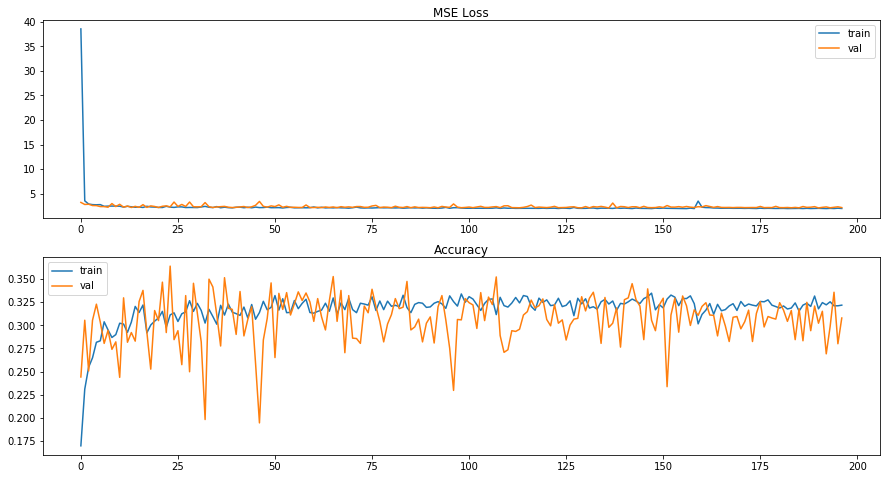

In [20]:
# import EarlyStopping
from keras.callbacks import EarlyStopping

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features))) 
model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')
model.compile(loss='mse', optimizer='adam', metrics=[metrics.mae, 'accuracy'])

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=60)

# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=4000, verbose=0, callbacks=[es]) 

# evaluate the model
train_acc = model.evaluate(train_X, train_y, verbose=1)

val_acc = model.evaluate(val_X, val_y, verbose=1)
print(train_acc, val_acc)
print(model.metrics_names)
print('Train: %.3f, Val: %.3f' % (train_acc[2], val_acc[2]))

# plot loss learning curves
plt.figure(figsize = (15, 8))
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

### Salva modello 

In [22]:
model.save('LSTM_MultistepForcast_early_stopping.h5')

### Calcola errore per tutte le celle

In [7]:
dict2data={} 
count = 0
for i,k in agg_by_cell:
    cell = i
    print(cell)
    count +=1
    if count > 3:break
    serie_dati = k['nr_people'].values
    
    # split into samples
    X, y = split_sequence(serie_dati, n_steps_in, n_steps_out)
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # train-validation-test
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
  
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features))) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # fit model
    model.fit(train_X, train_y, epochs=200, verbose=2)
    
    # predict and compute error
    predicted = np.array([])

    for i in range(len(val_X)):
        x_input = val_X[i].reshape((1, n_steps_in, n_features))
        yhat = model.predict(x_input, verbose=0)
        predicted = np.append(predicted, yhat[0]) 

    #predicted = predicted.reshape(-1, 1)    
    expected = val_y   
    expected = np.reshape(expected, (expected.shape[0]*expected.shape[1]))
    
    # abs difference
    error = abs((expected - predicted))
    print('Mean Absolute Error = ', np.mean(error))
    
    # collect data 2 dictionary
    minimum = np.amin(error)   
    per75 = np.percentile(error, 75)
    per50 = np.percentile(error, 50)
    per25 = np.percentile(error, 25)
    maximum = np.amax(error)
    l5i = [minimum, per25, per50, per75, maximum]
    #l5i = ','.join(l5i)
    dict2data[cell] = l5i
    
    # plot data
    plt.figure(figsize = (14,4))
    plt.boxplot(error, vert= False);
    plt.show()
    
with open('error_data_4_LSTM_MultistepForcast_25.csv', 'w') as f:
    for key, value in dict2data.items():
        f.write('%s:%s\n' % (key, value))    

486-1252


NameError: name 'n_steps_in' is not defined